## Packages

In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import yfinance as yf
import datetime

## Data Pre-processing

In [2]:
df = pd.read_csv('df_merged.csv')
# df.columns = ['date','open', 'high', 'low', 'close', 'adj_close', 'vol']
# df = df.sort_values(by = ['date'], ascending=True)
df.index = pd.to_datetime(df['date'])
df.drop(['date'], axis=1, inplace=True)
df

open          high           low         close  \
date                                                                 
2018-01-01  14112.200195  14112.200195  13154.700195  13657.200195   
2018-01-02  13625.000000  15444.599609  13163.599609  14982.099609   
2018-01-03  14978.200195  15572.799805  14844.500000  15201.000000   
2018-01-04  15270.700195  15739.700195  14522.200195  15599.200195   
2018-01-05  15477.200195  17705.199219  15202.799805  17429.500000   
...                  ...           ...           ...           ...   
2023-12-27  42518.468750  43683.160156  42167.582031  43442.855469   
2023-12-28  43468.199219  43804.781250  42318.550781  42627.855469   
2023-12-29  42614.644531  43124.324219  41424.062500  42099.402344   
2023-12-30  42091.753906  42584.125000  41556.226562  42156.902344   
2023-12-31  42152.097656  42860.937500  41998.253906  42265.187500   

            avg-block-size    blocks-size  cost-per-transaction    difficulty  \
date                                                                            
2018-01-01        1.043383  150110.786114            135.535323  1.922581e+12   
2018-01-02        1.041368  150273.540487            113.842161  1.931136e+12   
2018-01-03        1.065513  150451.629839            102.462144  1.931136e+12   
2018-01-04        1.065833  150618.904617            100.526983  1.931136e+12   
2018-01-05        1.067636  150797.951213            114.399122  1.931136e+12   
...                    ...            ...                   ...           ...   
2023-12-27        1.675623  536911.233276             84.338006  7.200615e+13   
2023-12-28        1.699762  537127.440801            101.689873  7.200615e+13   
2023-12-29        1.681139  537333.036574             84.433358  7.200615e+13   
2023-12-30        1.625427  537586.842334             92.458212  7.200615e+13   
2023-12-31        1.699324  537822.520338             77.176236  7.200615e+13   

               hash-rate    market-cap  ...  miners-revenue  \
date                                    ...                   
2018-01-01  1.497558e+07  2.253099e+11  ...    3.285810e+07   
2018-01-02  1.641554e+07  2.332635e+11  ...    3.994676e+07   
2018-01-03  1.507158e+07  2.513926e+11  ...    4.103701e+07   
2018-01-04  1.612755e+07  2.490912e+11  ...    4.272477e+07   
2018-01-05  1.372762e+07  2.645665e+11  ...    3.920538e+07   
...                  ...           ...  ...             ...   
2023-12-27  4.617484e+08  8.393480e+11  ...    4.678305e+07   
2023-12-28  4.331128e+08  8.407612e+11  ...    4.242298e+07   
2023-12-29  5.404962e+08  8.319130e+11  ...    4.909369e+07   
2023-12-30  5.190195e+08  8.258545e+11  ...    4.935632e+07   
2023-12-31  5.583934e+08  8.317620e+11  ...    5.644292e+07   

            n-transactions-excluding-popular  n-transactions-per-block  \
date                                                                     
2018-01-01                          231679.0               1549.724359   
2018-01-02                          324425.0               1994.035088   
2018-01-03                          376433.0               2522.057325   
2018-01-04                          402643.0               2529.809524   
2018-01-05                          322200.0               2396.552448   
...                                      ...                       ...   
2023-12-27                          545337.0               4229.116279   
2023-12-28                          416945.0               3447.768595   
2023-12-29                          581212.0               3850.655629   
2023-12-30                          533601.0               3681.537931   
2023-12-31                          731152.0               4688.147436   

            n-transactions-total  n-transactions  output-volume  \
date                                                              
2018-01-01           287846198.0        241757.0   1.683245e+06   
2018-01-02           288087874.0        340980.0   2.536939e+06   
2018

In [4]:
# Prepare the volume and price differences, normalize volume
# BTC_vol = df["vol"].values
df_diff = df.diff().dropna() # difference of df
# df_diff["vol"] = np.log(1 + BTC_vol[:-1])  # Shifted by 1 to align with diff
df_aligned = df.loc[df_diff.index]
mask_train = (df_diff.index >= "2018-01-01") & (df_diff.index <= "2022-12-31")
df_train = df_diff.loc[mask_train].copy()
# Use df_aligned to ensure the indexes match
train_close = df_aligned.loc[mask_train, "close"].values

# Since indexes are aligned, this operation should now work without error
# df_train["Relative_Close"] = train_close / train_close[0]

df_train

open         high          low        close  \
date                                                             
2018-01-02  -487.200195  1332.399414     8.899414  1324.899414   
2018-01-03  1353.200195   128.200195  1680.900391   218.900391   
2018-01-04   292.500000   166.900391  -322.299805   398.200195   
2018-01-05   206.500000  1965.499023   680.599609  1830.299805   
2018-01-06  1984.899414     7.201172  1561.799805    97.500000   
...                 ...          ...          ...          ...   
2022-12-27    77.041016    39.722656  -170.296875  -202.630859   
2022-12-28  -202.890625  -191.675781  -144.515625  -164.601562   
2022-12-29  -164.078125  -116.414062    11.126953    89.769531   
2022-12-30    89.007812    -8.328125  -100.208984   -39.755859   
2022-12-31   -37.656250   -14.441406   109.044922   -55.089844   

            avg-block-size  blocks-size  cost-per-transaction    difficulty  \
date                                                                          
2018-01-02       -0.002015   162.754373            -21.693162  8.555850e+09   
2018-01-03        0.024146   178.089352            -11.380017  0.000000e+00   
2018-01-04        0.000319   167.274778             -1.935161  0.000000e+00   
2018-01-05        0.001803   179.046596             13.872140  0.000000e+00   
2018-01-06       -0.013027   152.731365             15.360329  0.000000e+00   
...                    ...          ...                   ...           ...   
2022-12-27        0.257142   144.274855             -9.782225  0.000000e+00   
2022-12-28       -0.350080   158.907030             13.197474  0.000000e+00   
2022-12-29        0.236887   172.016181             -9.063155  0.000000e+00   
2022-12-30        0.093218   178.080295              1.123732  0.000000e+00   
2022-12-31       -0.284719   214.227307             10.140127  0.000000e+00   

               hash-rate    market-cap  ...  miners-revenue  \
date                                    ...                   
2018-01-02  1.439960e+06  7.953589e+09  ...    7.088660e+06   
2018-01-03 -1.343962e+06  1.812910e+10  ...    1.090252e+06   
2018-01-04  1.055970e+06 -2.301321e+09  ...    1.687761e+06   
2018-01-05 -2.399933e+06  1.547523e+10  ...   -3.519392e+06   
2018-01-06  2.399933e+06  1.544869e+10  ...    7.358410e+06   
...                  ...           ...  ...             ...   
2022-12-27 -2.461140e+07 -9.284377e+08  ...   -1.614336e+06   
2022-12-28  9.317173e+07 -3.074664e+09  ...    5.354965e+06   
2022-12-29 -4.746485e+07 -9.181832e+08  ...   -2.867642e+06   
2022-12-30  2.988527e+07 -8.365444e+08  ...    1.738261e+06   
2022-12-31 -3.515915e+06  4.936007e+08  ...   -3.394552e+05   

            n-transactions-excluding-popular  n-transactions-per-block  \
date                                                                     
2018-01-02                           92746.0                444.310729   
2018-01-03                           52008.0                528.022237   
2018-01-04                           26210.0                  7.752199   
2018-01-05                          -80443.0               -133.257076   
2018-01-06                           20479.0               -260.558400   
...                                      ...                       ...   
2022-12-27                           15823.0                348.793461   
2022-12-28                           33569.0               -456.686180   
2022-12-29                           -7013.0                261.509245   
2022-12-30                           25039.0                -44.338585   
2022-12-31                          -48605.0               -288.501704   

            n-transactions-total  n-transactions  output-volume  \
date                                                              
2018-01-02              241676.0         99223.0  853693.766232   
2018-01-03              341182.0         54983.0  279946.016717   
2018-01-04              396637.0         29045.0  -79059.151038   
2018-01-05    

In [5]:
mask_test = (df_diff.index >= "2023-01-01") & (df_diff.index <= "2023-12-31")  # December 2018 for testing
df_test = df_diff.loc[mask_test].copy()
test_close = df_aligned.loc[mask_test, "close"].values
# df_test["Relative_Close"] = test_close / train_close[0]
df_test

open        high         low       close  avg-block-size  \
date                                                                          
2023-01-01   -55.759766    1.453125    3.714844   77.583984       -0.229010   
2023-01-02    77.595703  128.904297   50.994141   63.390625        0.178520   
2023-01-03    63.337891    1.103516   50.142578   -8.613281        0.227036   
2023-01-04    -8.642578  204.138672   45.392578  183.380859       -0.023806   
2023-01-05   183.267578  -80.564453  122.519531  -26.501953       -0.069425   
...                 ...         ...         ...         ...             ...   
2023-12-27 -1081.378906   79.984375  491.093750  922.453125       -0.090081   
2023-12-28   949.730469  121.621094  150.968750 -815.000000        0.024139   
2023-12-29  -853.554688 -680.457031 -894.488281 -528.453125       -0.018622   
2023-12-30  -522.890625 -540.199219  132.164062   57.500000       -0.055712   
2023-12-31    60.343750  276.812500  442.027344  108.285156        0.073897   

            blocks-size  cost-per-transaction    difficulty     hash-rate  \
date                                                                        
2023-01-01   167.280558             18.672292  0.000000e+00 -1.757957e+06   
2023-01-02   130.593933            -14.536744  0.000000e+00  1.757957e+06   
2023-01-03   159.245033            -12.013734 -1.154996e+12 -1.235785e+07   
2023-01-04   192.549611             -4.114519 -1.154996e+11 -1.952700e+07   
2023-01-05   174.724398              5.309258  0.000000e+00  2.372721e+07   
...                 ...                   ...           ...           ...   
2023-12-27   245.388589              4.096417 -7.812500e-02 -3.579445e+07   
2023-12-28   216.207525             17.351867  0.000000e+00 -2.863556e+07   
2023-12-29   205.595773            -17.256515  1.562500e-01  1.073833e+08   
2023-12-30   253.805760              8.024855 -3.125000e-02 -2.147667e+07   
2023-12-31   235.678004            -15.281977  4.687500e-02  3.937389e+07   

              market-cap  ...  miners-revenue  \
date                      ...                   
2023-01-01 -2.516038e+08  ...   -2.025419e+05   
2023-01-02  2.770948e+09  ...    2.739871e+05   
2023-01-03 -2.887251e+07  ...    6.402105e+04   
2023-01-04  2.502068e+09  ...   -9.969402e+05   
2023-01-05 -2.739302e+07  ...    1.676481e+06   
...                  ...  ...             ...   
2023-12-27 -9.686815e+07  ...    2.353845e+06   
2023-12-28  1.413200e+09  ...   -4.360070e+06   
2023-12-29 -8.848208e+09  ...    6.670710e+06   
2023-12-30 -6.058527e+09  ...    2.626289e+05   
2023-12-31  5.907465e+09  ...    7.086597e+06   

            n-transactions-excluding-popular  n-transactions-per-block  \
date                                                                     
2023-01-01                          -54721.0               -343.584739   
2023-01-02                           41739.0                260.392432   
2023-01-03                           42659.0                296.417832   
2023-01-04                            5863.0                177.017483   
2023-01-05                            1464.0               -164.047882   
...                                      ...                       ...   
2023-12-27                           -8086.0                245.713401   
2023-12-28                         -128392.0               -781.347684   
2023-12-29                          164267.0                402.887034   
2023-12-30                          -47611.0               -169.117698   
2023-12-31                          197551.0               1006.609505   

            n-transactions-total  n-transactions  output-volume  \
date                                                              
2023-01-01              243379.0        -54809.0  -69276.988571   
2023-01-02              186842.0         41831.0  130051.645395   
2023-01-03              228331.0         42708.0  139592.631805   
2023-01-04              273040.0          5881.0   46

## MLP (flattening the previous 5-day data)

In [6]:
def gen_dataset_MLP(df, seq_len):
    df_X_extract = df.drop('close', axis=1)
    # [['open','high','low','vol','Relative_Close']]
    df_X = pd.DataFrame(columns=np.arange(0, (df.shape[1]-1)*seq_len))
    df_y = df[['close']][seq_len:]
    for i in range(len(df) - seq_len):
        df_i = pd.DataFrame(df_X_extract.iloc[i:(i+seq_len)].values.flatten(), columns=[0])
        df_X = pd.concat([df_X, df_i.T], axis=0)
    df_X = df_X.reset_index(drop=True)
    return df_X, df_y

In [7]:
X_train_MLP, y_train_MLP = gen_dataset_MLP(df_train, 5)

In [8]:
X_test_MLP, y_test_MLP = gen_dataset_MLP(df_test, 5)

In [9]:
X_train_MLP.shape

(1820, 100)

In [92]:
# Best Model Test
def build_model(num_layers, act_fcn, neuron, dropout, train_df = X_train_MLP):
    # tf.keras.backend.clear_session()
    tf.keras.utils.set_random_seed(4012)
    
    model = Sequential()
    model.add(tf.keras.Input(shape=(train_df.shape[1],)))
    model.add(Dense(neuron, activation=act_fcn))
    
    for _ in range(num_layers):
        model.add(Dense(neuron, activation=act_fcn))

    model.add(Dropout(dropout))
    model.add(Dense(1))
    return model

num_layers_list = [0, 1, 2, 3]  
activation_fcns = ['sigmoid', 'relu']
neurons = [32, 64, 128]
dropouts = [0, 0.2, 0.5, 0.7]
feat_eng = ['raw','Standard','MinMax','Robust']
mse = tf.keras.losses.MeanSquaredError()
# mae = tf.keras.losses.MeanAbsoluteError()

for feat in feat_eng:
    no_lay_df = pd.DataFrame(columns = ['No_layers','Act_Fcns','Neurons','Dropout','MSE',
                                        # 'MAE'
                                        ])
    if feat == 'Standard':
        scaler = StandardScaler()
    elif feat == 'MinMax':
        scaler = MinMaxScaler()
    elif feat == 'Robust':
        scaler = RobustScaler()

    if feat != 'raw':
        scaled_X_train = scaler.fit_transform(X_train_MLP)
        scaled_y_train = scaler.fit_transform(y_train_MLP)
        scaled_X_test = scaler.fit_transform(X_test_MLP)
        scaled_y_test = scaler.fit_transform(y_test_MLP)

    for num_layers in num_layers_list:
        for act_fcn in activation_fcns:
            for neuron in neurons:
                for dropout in dropouts:
                    model = build_model(num_layers, act_fcn, neuron, dropout)
                    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
                    model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
                    if feats == 'raw':
                        model.fit(X_train_MLP, y_train_MLP, batch_size=64, epochs=100, shuffle=True)
                        pred_MLP = model.predict(X_test_MLP)
                    else: 
                        model.fit(scaled_X_train, scaled_y_train, batch_size=64, epochs=100, shuffle=True)
                        scaled_pred_MLP = model.predict(scaled_X_test)
                        pred_MLP = scaler.inverse_transform(scaled_pred_MLP)
                    mse_MLP = mse(y_test_MLP, pred_MLP).numpy()
                    # mae_MLP = mae(y_test_MLP, pred_MLP).numpy()

                    no_lay_df_new = pd.DataFrame(dict(No_layers=[num_layers+1], Act_Fcns=[act_fcn],Neurons=[neuron], Dropout=[dropout], MSE=[mse_MLP],
                                                    #   MAE=[mae_MLP]
                                                    ))
                    no_lay_df = pd.concat([no_lay_df, no_lay_df_new], axis=0, ignore_index=True)

    no_lay_df.to_csv(f'MLP_daily_combined_{feat}_MSE_new.csv',index=False)

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - accuracy: 0.0000e+00 - loss: 5.2004
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - accuracy: 0.0000e+00 - loss: 4.9954
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - accuracy: 0.0000e+00 - loss: 4.9616
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.0000e+00 - loss: 4.9327
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.0000e+00 - loss: 4.8930
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.0000e+00 - loss: 4.8445
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - accuracy: 0.0000e+00 - loss: 4.8641
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - accuracy: 0.0000e+00 - loss: 4.8447
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - accuracy: 0.0000e+00 - loss: 4.8345
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - accuracy: 0.0000e+00 - loss: 4.8478
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.0000e+00 - loss: 4.81

# LSTM (naive)

In [75]:
# Generate dataset function for LSTM
def generate_dataset_LSTM(df, seq_len):
    X_list, y_list = [], []
    for i in range(len(df) - seq_len):
        X_list.append(df.iloc[i:(i+seq_len), :].values)
        y_list.append(df["close"].iloc[i + seq_len])
    return np.array(X_list), np.array(y_list)

In [76]:
LAG = 5 # Example: Use the past # days to predict the next day
# Prepare training and test datasets
X_train_LSTM, y_train_LSTM = generate_dataset_LSTM(df_train, LAG)
X_test_LSTM, y_test_LSTM = generate_dataset_LSTM(pd.concat((df_train.iloc[-LAG:], df_test)), LAG)
X_train_LSTM.shape

(1820, 5, 21)

In [77]:
# model architecture
tf.keras.utils.set_random_seed(4012)
model = Sequential([
    LSTM(8, return_sequences=True, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])),
    LSTM(8, dropout=0.2),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# train the dataset
model.fit(X_train_LSTM, y_train_LSTM, batch_size=64, epochs=30, shuffle=True) 

Epoch 1/30


c:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1005807.5625
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1005811.6875
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1005805.1875
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1005800.4375
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1005801.1875
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1005799.0625
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1005805.5000
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1005796.0000
Epoch 9/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1005797.8750
Epoch 10/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1005794.8750
Epoch 11/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1005785.1250
Epoch 12/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1005786.6250
Epoch 13/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1005767.1875
Epoch 14/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1005772.7500
Epoch 15/30


In [82]:
mse_LSTM = np.mean((pred_LSTM - y_test_LSTM)**2)
print("Test MSE:", mse_LSTM)

Test MSE: 429951.70405946806


# Plots

In [93]:
df = pd.read_csv(f'MLP_daily_combined_raw_MSE_new.csv')
df.columns = ['No_layers','Act_Fcns','Neurons','Dropout','MSE_raw']
feat_eng = ['Standard','MinMax','Robust']
for feat in feat_eng:
    df_feat = pd.read_csv(f'MLP_daily_combined_{feat}_MSE_new.csv')
    df_i = pd.DataFrame(np.array(df_feat['MSE']), columns=[f'MSE_{feat}'])
    # df_i.columns = ['No_layers','Act_Fcns','Neurons','Dropout',f'MSE_{feat}']
    df = pd.concat([df,df_i], axis=1)
df.to_csv(f'MLP_daily_combined_MSE_new.csv', index=False)
df

No_layers Act_Fcns  Neurons  Dropout    MSE_raw  MSE_Standard  MSE_MinMax  \
0           1  sigmoid       32      0.0  515084.72     468160.56   513899.80   
1           1  sigmoid       32      0.2  477961.80     430956.44   609892.90   
2           1  sigmoid       32      0.5  460815.20     432142.56   522216.62   
3           1  sigmoid       32      0.7  456799.47     429369.78   512254.12   
4           1  sigmoid       64      0.0  518313.28     549564.44   597577.56   
..        ...      ...      ...      ...        ...           ...         ...   
91          4     relu       64      0.7        NaN     521025.78   542141.75   
92          4     relu      128      0.0        NaN     479887.50   584380.44   
93          4     relu      128      0.2        NaN     506391.78   650257.06   
94          4     relu      128      0.5        NaN     475505.88   616118.10   
95          4     relu      128      0.7        NaN     522556.30   581662.40   

    MSE_Robust  
0    515084.72  
1    477961.80  
2    460815.20  
3    456799.47  
4    518313.28  
..         ...  
91         NaN  
92         NaN  
93         NaN  
94         NaN  
95         NaN  

[96 rows x 8 columns]

In [102]:
feat_eng = ['raw','Standard','MinMax','Robust']
for feat in feat_eng:    
    print(feat, df[df[f'MSE_{feat}']== np.nanmin(df[f'MSE_{feat}'])].iloc[:,:4])
    print(feat, df[df[f'MSE_{feat}']== np.nanmin(df[f'MSE_{feat}'])][f'MSE_{feat}'])


raw    No_layers Act_Fcns  Neurons  Dropout
3          1  sigmoid       32      0.7
raw 3    456799.47
Name: MSE_raw, dtype: float64
Standard    No_layers Act_Fcns  Neurons  Dropout
3          1  sigmoid       32      0.7
Standard 3    429369.78
Name: MSE_Standard, dtype: float64
MinMax     No_layers Act_Fcns  Neurons  Dropout
36          2     relu       32      0.0
MinMax 36    450673.9
Name: MSE_MinMax, dtype: float64
Robust    No_layers Act_Fcns  Neurons  Dropout
3          1  sigmoid       32      0.7
Robust 3    456799.47
Name: MSE_Robust, dtype: float64


In [103]:
# Model 1: No Scaling
tf.keras.utils.set_random_seed(4012)
model1 = Sequential()
model1.add(tf.keras.Input(shape=(X_train_MLP.shape[1],))) # input features
model1.add(Dense(32, activation='sigmoid'))
# model1.add(Dense(64, activation='sigmoid'))
# model1.add(Dense(64, activation='sigmoid'))
# model1.add(Dense(64, activation='sigmoid'))
model2.add(Dropout(0.7))
model1.add(Dense(1))

model1.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model1.fit(X_train_MLP, y_train_MLP, batch_size=64, epochs=100, shuffle=True)

mse = tf.keras.losses.MeanSquaredError()
pred_MLP1 = model1.predict(X_test_MLP)
mse_MLP1 = mse(y_test_MLP, pred_MLP1).numpy()
# mse_LSTM = mse(y_test_LSTM, pred_LSTM)

mse_MLP1

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - loss: 1005820.2500
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 1005814.6250
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 1005811.6875
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 1005808.7500
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 1005805.6875
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 1005802.8750
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 1005799.9375
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 1005796.9375
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 1005794.0000
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 1005791.1250
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 1005788.1875
Epoch 12/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 1005785.2500
Epoch 13/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 1005782.2500
Epoch 14/100
29/29 ━━━━━━━━━━━━━━━

436232.72

In [55]:
# Model 2: Standard Scaling
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train_MLP)
scaled_y_train = scaler.fit_transform(y_train_MLP)
scaled_X_test = scaler.fit_transform(X_test_MLP)
scaled_y_test = scaler.fit_transform(y_test_MLP)

tf.keras.utils.set_random_seed(4012)
model2 = Sequential()
model2.add(tf.keras.Input(shape=(X_train_MLP.shape[1],))) # input features
model2.add(Dense(32, activation='sigmoid'))
# model2.add(Dense(64, activation='sigmoid'))
# model2.add(Dense(64, activation='sigmoid'))
model2.add(Dropout(0.7))
model2.add(Dense(1))

model2.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model2.fit(scaled_X_train, scaled_y_train, batch_size=64, epochs=100, shuffle=True)

scaled_pred_MLP2 = model2.predict(scaled_X_test)
pred_MLP2 = scaler.inverse_transform(scaled_pred_MLP2)
mse_MLP2 = mse(y_test_MLP, pred_MLP2).numpy()
# mse_LSTM = mse(y_test_LSTM, pred_LSTM)

mse_MLP2

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - loss: 2.1649
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 1.9514
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 1.8236
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 1.6964
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 1.5475
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 1.4835
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 1.3751
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - loss: 1.3014
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 1.2656
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 1.1969
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1791 
Epoch 12/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - loss: 1.1660
Epoch 13/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 1.1290
Epoch 14/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 1.1014
Epoch 15/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5

429369.78

In [104]:
# Model 3: MinMax Scaling
scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train_MLP)
scaled_y_train = scaler.fit_transform(y_train_MLP)
scaled_X_test = scaler.fit_transform(X_test_MLP)
scaled_y_test = scaler.fit_transform(y_test_MLP)

tf.keras.utils.set_random_seed(4012)
model3 = Sequential()
model3.add(tf.keras.Input(shape=(X_train_MLP.shape[1],))) # input features
model3.add(Dense(32, activation='relu'))
model3.add(Dense(32, activation='relu'))
# model3.add(Dense(64, activation='sigmoid'))
# model3.add(Dense(64, activation='sigmoid'))
# model2.add(Dropout(0.5))
model3.add(Dense(1))

model3.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model3.fit(scaled_X_train, scaled_y_train, batch_size=64, epochs=100, shuffle=True)

scaled_pred_MLP3 = model3.predict(scaled_X_test)
pred_MLP3 = scaler.inverse_transform(scaled_pred_MLP3)
mse_MLP3 = mse(y_test_MLP, pred_MLP3).numpy()
# mse_LSTM = mse(y_test_LSTM, pred_LSTM)

mse_MLP3

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 0.2026 
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - loss: 0.0079
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 0.0066
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 0.0062
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 0.0060
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 0.0058
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 0.0056
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 0.0055
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 0.0055
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - loss: 0.0054
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 0.0053
Epoch 12/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 0.0053
Epoch 13/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 0.0053
Epoch 14/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 0.0052
Epoch 15/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s

450673.9

In [57]:
# Model 4: Robust Scaling
scaler = RobustScaler()
scaled_X_train = scaler.fit_transform(X_train_MLP)
scaled_y_train = scaler.fit_transform(y_train_MLP)
scaled_X_test = scaler.fit_transform(X_test_MLP)
scaled_y_test = scaler.fit_transform(y_test_MLP)

tf.keras.utils.set_random_seed(4012)
model4 = Sequential()
model4.add(tf.keras.Input(shape=(X_train_MLP.shape[1],))) # input features
model4.add(Dense(32, activation='sigmoid'))
model4.add(Dropout(0.7))
model4.add(Dense(1))

model4.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model4.fit(scaled_X_train, scaled_y_train, batch_size=64, epochs=100, shuffle=True)

scaled_pred_MLP4 = model4.predict(scaled_X_test)
pred_MLP4 = scaler.inverse_transform(scaled_pred_MLP4)
mse_MLP4 = mse(y_test_MLP, pred_MLP4).numpy()
# mse_LSTM = mse(y_test_LSTM, pred_LSTM)

mse_MLP4

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - loss: 6.5523
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 6.3332
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 6.1406
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 6.1126
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 5.9374
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 5.7266
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 5.4935
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 5.4085
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 5.3085
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 5.3092
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 5.1875
Epoch 12/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 5.2813
Epoch 13/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 5.1545
Epoch 14/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 5.1505
Epoch 15/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 

456799.47

In [105]:
# DF storing pred_MLP
df_pred_MLP = pd.DataFrame(dict(
    date = df_test.index[5:],
    Original = np.array(df_test["close"][5:]),
    NoScaling = np.array(pred_MLP1.flatten()),
    Standard = np.array(pred_MLP2.flatten()),
    MinMax = np.array(pred_MLP3.flatten()),
    Robust = np.array(pred_MLP4.flatten())
))
df_pred_MLP.to_csv('MLP_daily_combined_pred_arr_new.csv', index=False)
df_pred_MLP

date    Original  NoScaling    Standard      MinMax      Robust
0   2023-01-06  115.232422   3.722349  146.725708  248.892548  185.938950
1   2023-01-07    3.109375   3.398906  125.614136  132.348907  280.001556
2   2023-01-08  136.066406   2.795516   60.846466  117.042374 -116.568581
3   2023-01-09  105.410156   2.795516   93.618965   96.295914 -146.749557
4   2023-01-10  249.738281  -2.168849   62.842171  206.721466 -161.668579
..         ...         ...        ...         ...         ...         ...
355 2023-12-27  922.453125  -2.345050  136.959991  119.347542 -291.611542
356 2023-12-28 -815.000000  -1.344227   42.206520  -19.928200   69.312881
357 2023-12-29 -528.453125  -1.899041  -61.869579  236.575531  150.564194
358 2023-12-30   57.500000   0.261448   18.525963  256.324829  -67.091705
359 2023-12-31  108.285156   1.709040  143.542160  157.947739  137.243744

[360 rows x 6 columns]

Text(0, 0.5, 'Difference in Price')

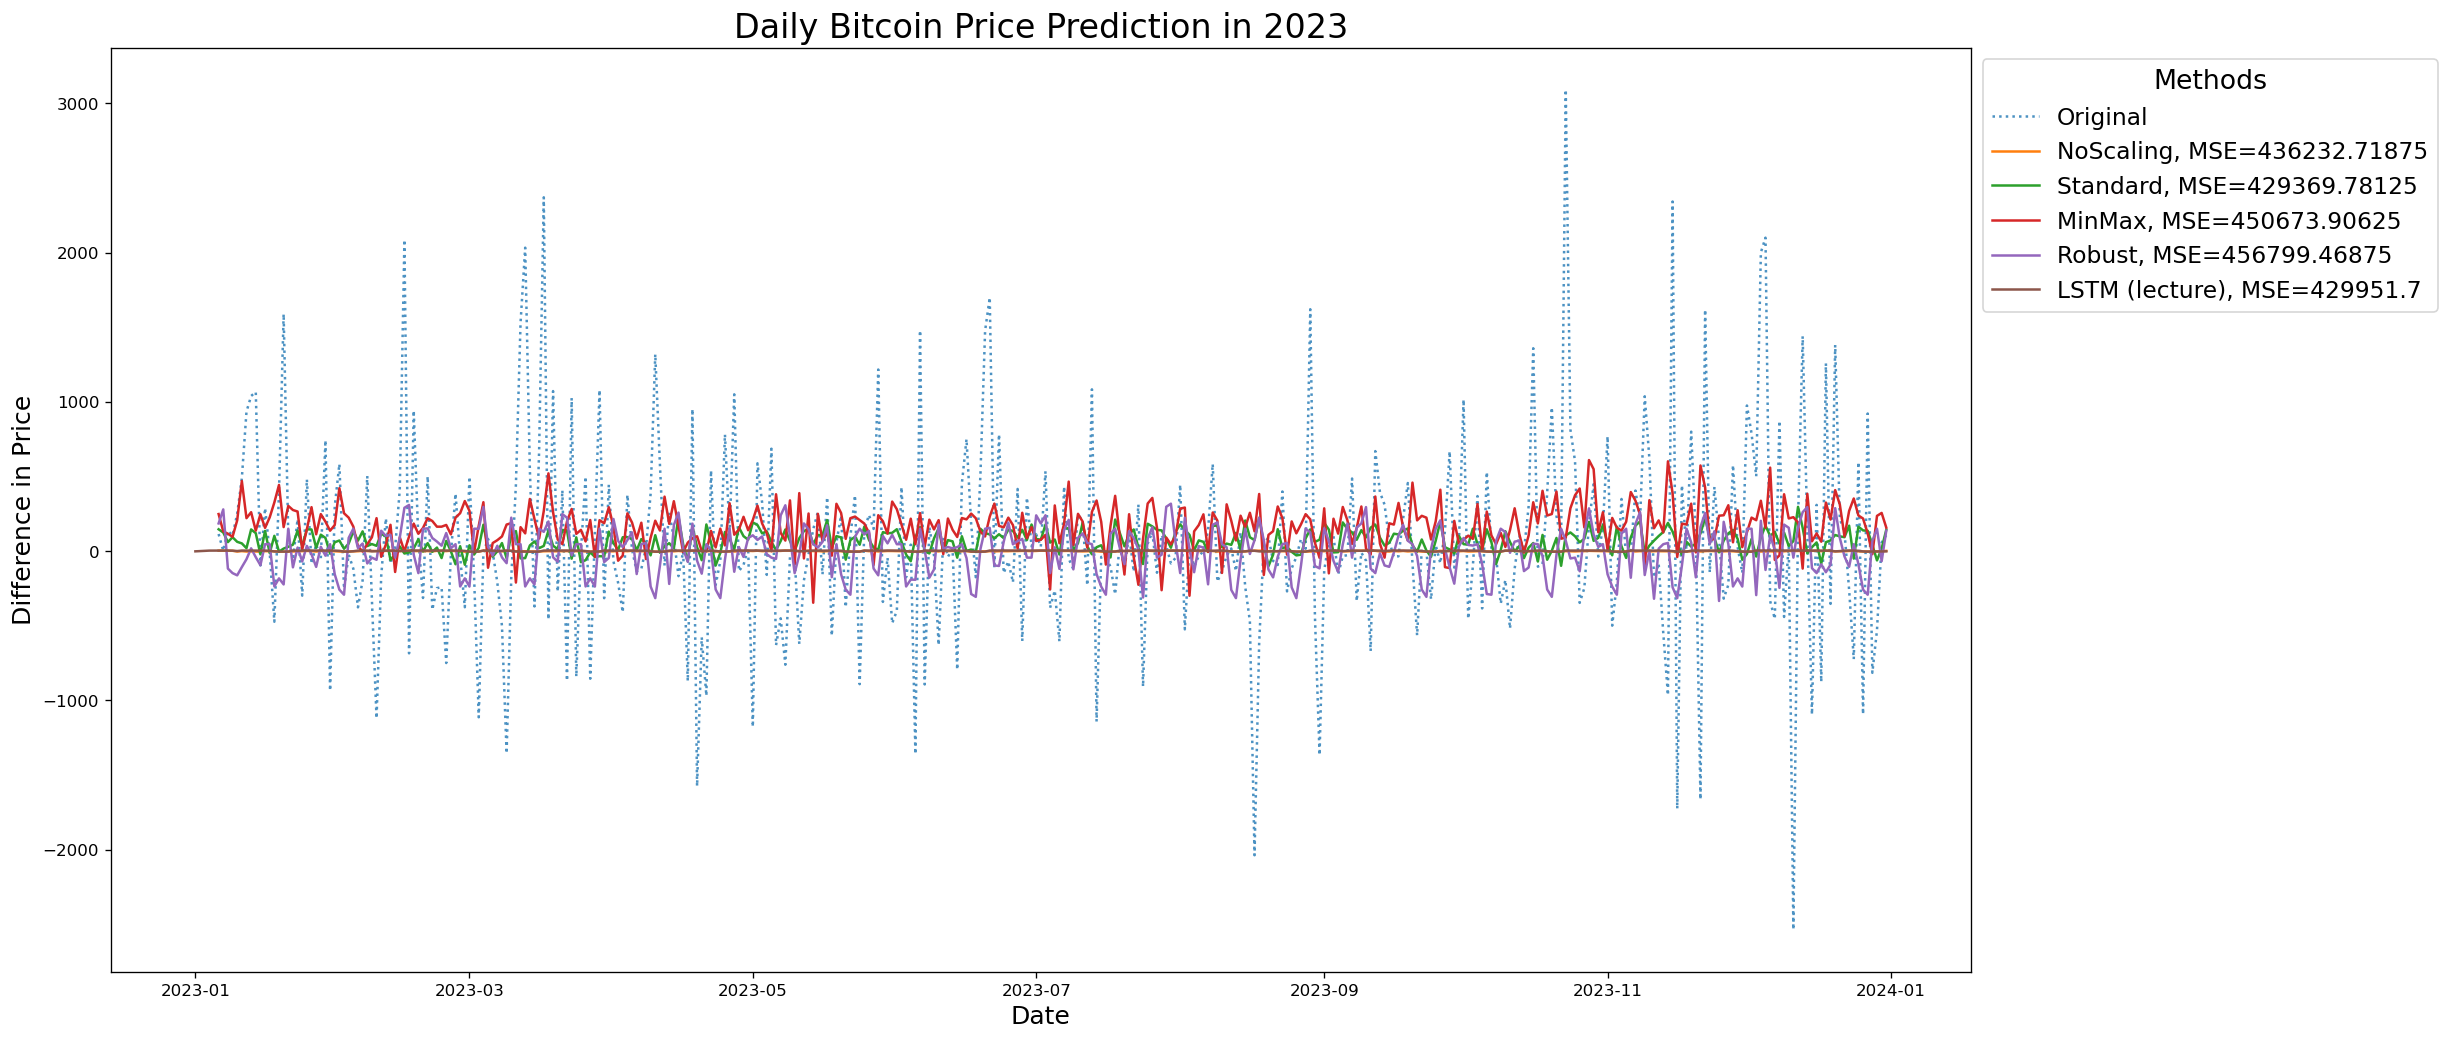

In [106]:
fig = plt.figure(figsize=(20,10), dpi=(1920/16))
mse = [mse_MLP1, mse_MLP2, mse_MLP3, mse_MLP4]
# plt.plot(np.array(df_test.index), pred_LSTM, label='LSTM (lecture)')
for i in np.arange(1,df_pred_MLP.shape[1]):
    if i == 1:
        plt.plot(df_pred_MLP['date'], df_pred_MLP.iloc[:,i], label=df_pred_MLP.columns[i], linestyle='dotted', alpha=0.8)
    else:
        plt.plot(df_pred_MLP['date'], df_pred_MLP.iloc[:,i], label=df_pred_MLP.columns[i] + f', MSE={mse[i-2]}')
plt.plot(df_test.index, pred_LSTM, label=f'LSTM (lecture), MSE={round(mse_LSTM, 2)}')
plt.legend(title='Methods',title_fontsize=16, fontsize=14, bbox_to_anchor=(1, 1))
plt.title('Daily Bitcoin Price Prediction in 2023', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Difference in Price', fontsize=15)

Text(0, 0.5, 'Difference in Price')

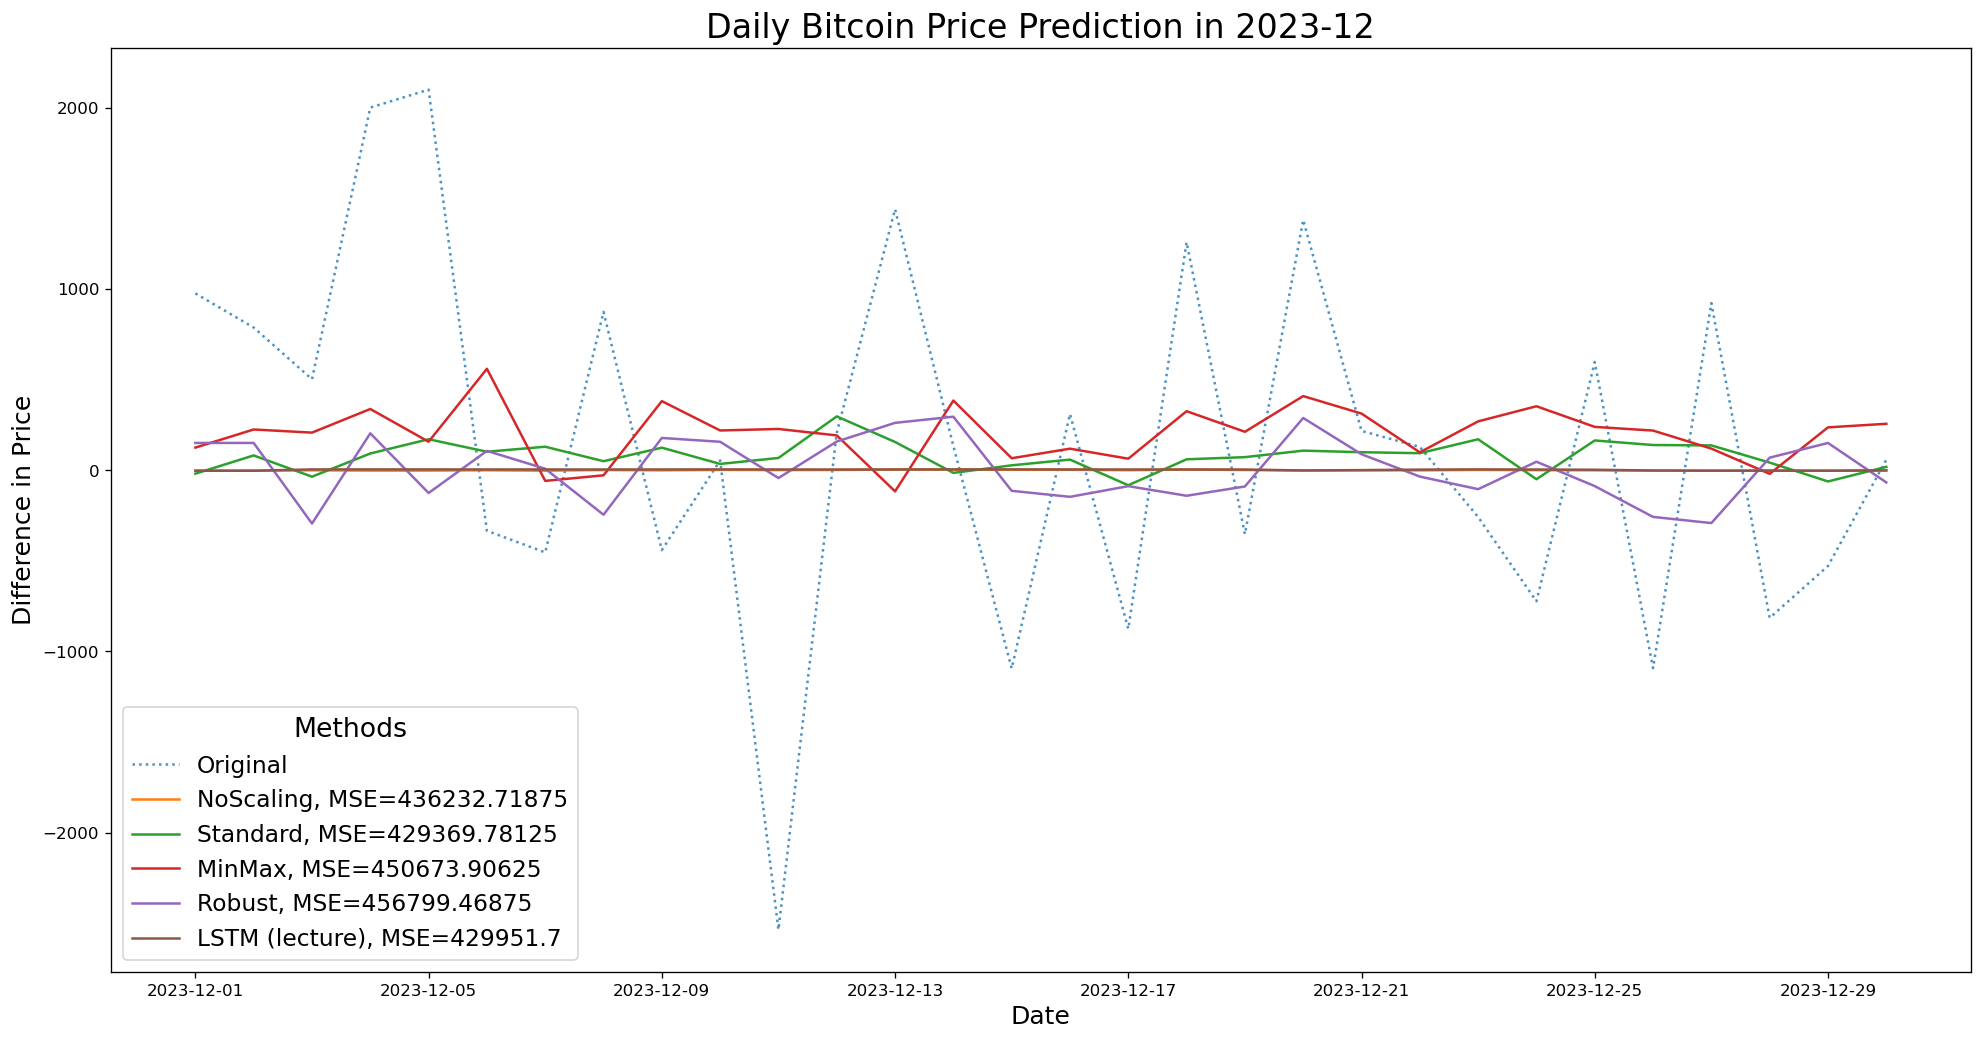

In [107]:
fig = plt.figure(figsize=(20,10), dpi=(1920/16))
mse = [mse_MLP1, mse_MLP2, mse_MLP3, mse_MLP4]
# plt.plot(np.array(df_test.index), pred_LSTM, label='LSTM (lecture)')
for i in np.arange(1,df_pred_MLP.shape[1]):
    if i == 1:
        plt.plot(df_pred_MLP['date'][-31:-1], df_pred_MLP.iloc[:,i][-31:-1], label=df_pred_MLP.columns[i], linestyle='dotted', alpha=0.8)
    else:
        plt.plot(df_pred_MLP['date'][-31:-1], df_pred_MLP.iloc[:,i][-31:-1], label=df_pred_MLP.columns[i]+ f', MSE={mse[i-2]}')
plt.plot(df_test.index[-31:-1], pred_LSTM[-31:-1], label=f'LSTM (lecture), MSE={round(mse_LSTM, 2)}')
plt.legend(title='Methods',title_fontsize=16, fontsize=14,)
plt.title('Daily Bitcoin Price Prediction in 2023-12', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Difference in Price', fontsize=15)